<a href="https://colab.research.google.com/github/likr/qiita-map/blob/main/notebooks/qiita.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
!apt-get -y install fonts-ipafont-gothic
!rm /root/.cache/matplotlib/fontlist-v300.json

Reading package lists... Done
Building dependency tree       
Reading state information... Done
fonts-ipafont-gothic is already the newest version (00303-18ubuntu1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.
rm: cannot remove '/root/.cache/matplotlib/fontlist-v300.json': No such file or directory


In [54]:
from google.colab import auth
auth.authenticate_user()

# Data Check

In [147]:
%%bigquery df --project vdslab-207906
SELECT
  created_date,
  COUNT(*) AS count
FROM (
  SELECT
    DATETIME_TRUNC(DATETIME(created_at, "+09:00"), DAY) AS created_date
  FROM
    `vdslab-207906.qiita.items`)
GROUP BY
  created_date
ORDER BY
  created_date;

Query is running:   0%|          |

Downloading:   0%|          |

In [148]:
from datetime import datetime, timedelta
from itertools import count
import pandas as pd
dates = {pd.to_datetime(row) for row in df['created_date'].values}
start_date = min(dates)
stop_date = max(dates)
for i in count():
    date = start_date + timedelta(days=i)
    if date > stop_date:
        break
    if date not in dates:
        print(date.strftime('%Y-%m-%d'))

2011-09-29
2011-10-22
2011-11-17
2011-11-19


# Yearly Posts

In [149]:
%%bigquery df --project vdslab-207906
SELECT
  year,
  COUNT(*) AS count
FROM (
  SELECT
    EXTRACT(YEAR
    FROM
      created_at) AS year
  FROM
    `vdslab-207906.qiita.items`)
GROUP BY
  year
ORDER BY
  year;

Query is running:   0%|          |

Downloading:   0%|          |

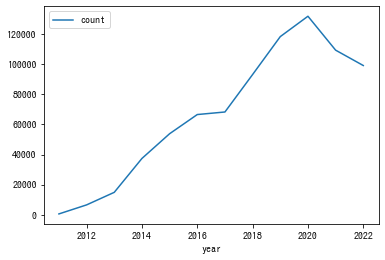

In [150]:
c = df.plot.line(x='year', y='count')

# Tags

In [151]:
%%bigquery df_tags --project vdslab-207906
SELECT
  tags.name AS tag,
  COUNT(*) AS count
FROM
  `vdslab-207906.qiita.items` items,
  items.tags
GROUP BY
  tag
ORDER BY
  count DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [152]:
df_tags.head()

,tag,count
0,Python,66873
1,JavaScript,49330
2,Ruby,37988
3,Rails,35972
4,AWS,33378


In [153]:
df_tags.describe()

,count
count,79076.000000
mean,27.689944
std,493.551238
min,1.000000
25%,1.000000
50%,2.000000
75%,5.000000
max,66873.000000


# Users

In [154]:
%%bigquery df_users --project vdslab-207906
SELECT
  ANY_VALUE(user.id) AS user_id,
  COUNT(*) AS count
FROM
  `vdslab-207906.qiita.items`
GROUP BY
  user.permanent_id
ORDER BY
  count DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [155]:
df_users.head()

,user_id,count
0,7of9,6154
1,kaizen_nagoya,5097
2,ohisama@github,3023
3,YumaInaura,2078
4,tukiyo3,1872


In [156]:
df_users.describe()

,count
count,93003.000000
mean,8.599411
std,36.428204
min,1.000000
25%,1.000000
50%,3.000000
75%,8.000000
max,6154.000000


# Tag Network

In [157]:
%%bigquery df_nodes --project vdslab-207906
SELECT
  tag,
  COUNT(*) AS count
FROM (
  SELECT
    DISTINCT tags.name AS tag,
    user.permanent_id AS user_id
  FROM
    `vdslab-207906.qiita.items` items,
    items.tags)
GROUP BY
  tag
ORDER BY
  count DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [158]:
%%bigquery df_edges --project vdslab-207906
CREATE TEMPORARY FUNCTION
  pairs(tags ARRAY<STRUCT<versions ARRAY<String>,
    name String>>)
  RETURNS ARRAY<STRUCT<tag1 String,
  tag2 String>>
  LANGUAGE js AS """
  const result = new Array(tags.length);
  for (let i = 0; i < tags.length; ++i) {
    for (let j = i + 1; j < tags.length; ++j) {
      result.push({
        tag1: tags[i].name,
        tag2: tags[j].name
      })
    }
  }
  return result;
""";
SELECT
  tag1,
  tag2,
  COUNT(*) AS count
FROM (
  SELECT
    DISTINCT pair.tag1 AS tag1,
    pair.tag2 AS tag2,
    user.permanent_id
  FROM
    `vdslab-207906.qiita.items` items,
    UNNEST(pairs(items.tags)) pair)
WHERE
  tag1 IS NOT NULL
  AND tag2 IS NOT NULL
GROUP BY
  tag1,
  tag2
ORDER BY
  count DESC

Query is running:   0%|          |

Downloading:   0%|          |

In [194]:
from math import sqrt
import networkx as nx
from networkx.algorithms import community

graph = nx.Graph()
for tag1, tag2, count in df_edges.values[:400]:
    graph.add_edge(tag1, tag2, count=count)
for tag, count in df_nodes.values:
    if tag in graph:
        graph.nodes[tag]['count'] = count
graph = graph.subgraph(max(nx.connected_components(graph), key=len)).copy()
for tag1, tag2 in graph.edges:
    n1 = set(graph.neighbors(tag1))
    n2 = set(graph.neighbors(tag2))
    # graph[tag1][tag2]['weight'] = min(
    #     sum(graph[tag1][tag3]['count'] for tag3 in n1), 
    #     sum(graph[tag2][tag3]['count'] for tag3 in n2))
    graph[tag1][tag2]['weight'] = min(len(n1), len(n2))
for i, tags in enumerate(community.greedy_modularity_communities(graph, n_communities=10)):
    for tag in tags:
        graph.nodes[tag]['community'] = i


In [206]:
from math import sqrt
from random import random
from networkx import floyd_warshall_numpy
from scipy.sparse.linalg import cg
from sklearn.manifold import MDS
import numpy as np

def inv(x):
    if x < 1e-4:
        return 0.0
    return 1 / x


def stress(X, D):
    n = len(X)
    s = 0
    for i in range(n):
        X_i = X[i, :]
        for j in range(i):
            X_j = X[j, :]
            d = np.linalg.norm(X_i - X_j) - D[i, j]
            s += d * d
    return s



def stress_majorization(graph):
    epsilon = 1e-4
    n = graph.number_of_nodes()
    D = floyd_warshall_numpy(graph)
    w = np.zeros((n, n))
    delta = np.zeros((n, n))
    for i in range(n):
        for j in range(i):
            w[i, j] = w[j, i] = D[i, j] ** -2
            delta[i, j] = delta[j, i] = w[i, j] * D[i, j]
    Z = MDS(dissimilarity='precomputed', random_state=5).fit_transform(D)
    Z[0] = (0., 0.)
    L_w = np.zeros((n, n))
    for i in range(n):
        for j in range(i):
            L_w[i, j] = L_w[j, i] = -w[i, j]
    for i in range(n):
        L_w[i, i] = -sum(L_w[i, :])
    e0 = stress(Z, D)
    while True:
        L_Z = np.zeros((n, n))
        for i in range(n):
            Z_i = Z[i, :]
            for j in range(i):
                Z_j = Z[j, :]
                L_Z[i, j] = L_Z[j, i] = -delta[i, j] * inv(np.linalg.norm(Z_i - Z_j))
        for i in range(n):
            L_Z[i][i] = -sum(L_Z[i, :])
        Z[1:, 0] = cg(L_w[1:, 1:], (L_Z @ Z[:, 0])[1:])[0]
        Z[1:, 1] = cg(L_w[1:, 1:], (L_Z @ Z[:, 1])[1:])[0]
        e = stress(Z, D)
        if (e0 - e) / e0 < epsilon:
            break
        e0 = e
    return {u: Z[i] for i, u in enumerate(graph.nodes())}
    
pos = stress_majorization(graph)

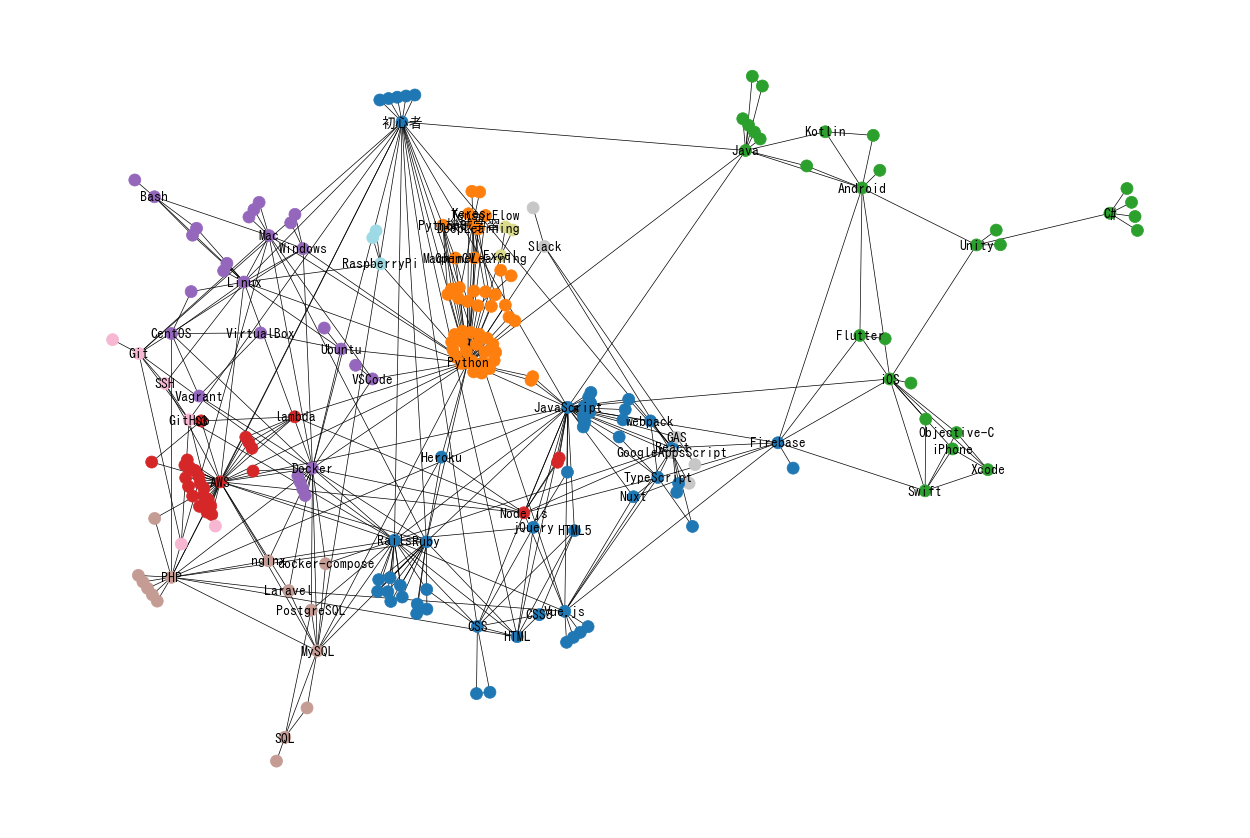

In [207]:
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt

font_manager.fontManager.addfont("/usr/share/fonts/opentype/ipafont-gothic/ipag.ttf")
matplotlib.rc('font', family="IPAGothic")
fig = plt.figure(1, figsize=(32, 32), dpi=50)
ax = plt.subplot(aspect='equal')
nx.draw(
    graph,
    ax=ax,
    pos=pos, 
    labels={tag: tag for tag in graph.nodes if graph.degree(tag) >= 3},
    node_color = [graph.nodes[tag]['community'] for tag in graph.nodes],
    cmap=matplotlib.cm.tab20,
    font_size=20,
    font_weight='bold',
    font_family='IPAGothic')

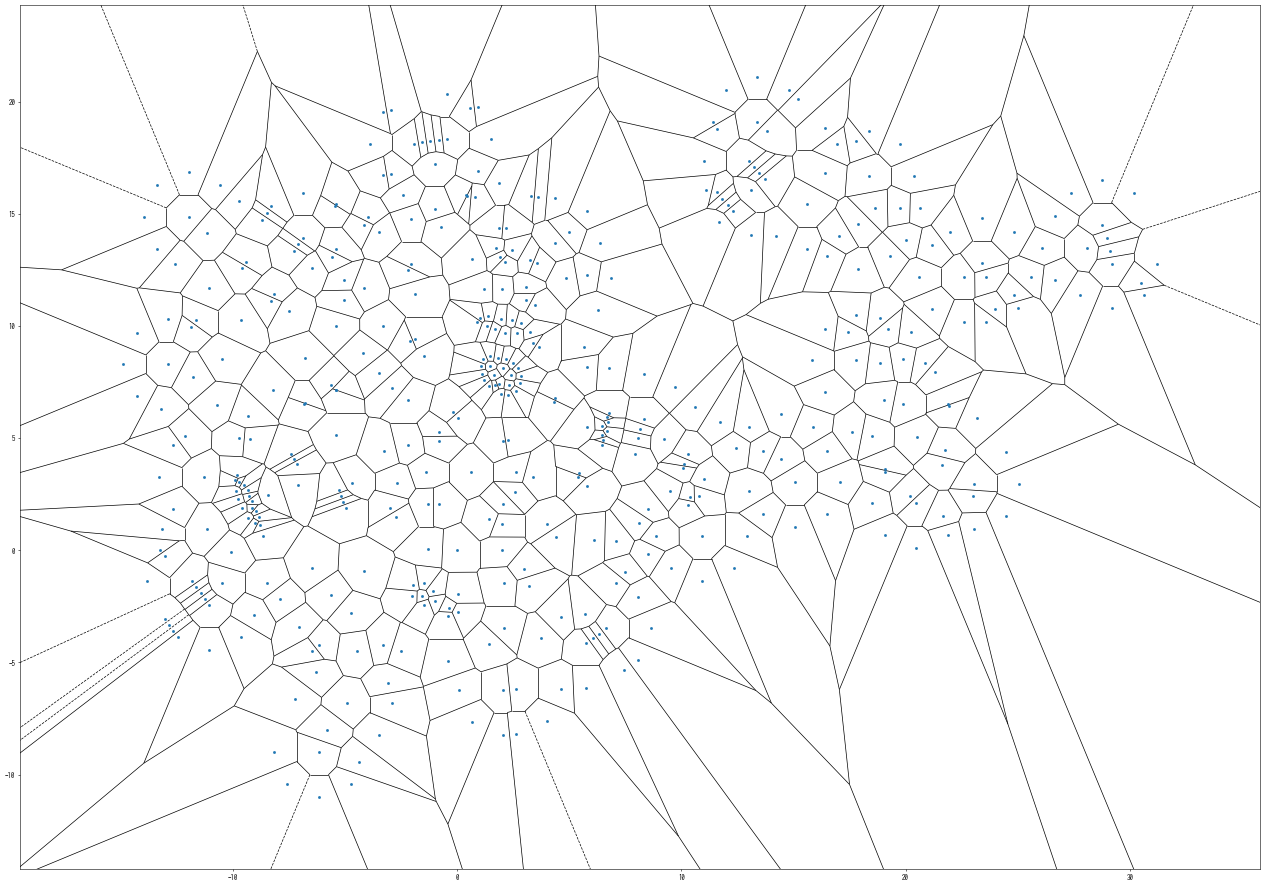

In [208]:
import math
from sklearn.neighbors import NearestNeighbors
from scipy.spatial import Voronoi, voronoi_plot_2d
import matplotlib.pyplot as plt
node_points = [pos[tag] for tag in graph]
neighbors = NearestNeighbors(n_neighbors=2, algorithm='ball_tree').fit(node_points)
points = list(node_points)
for cx, cy in node_points:
    n = 8
    r = 2
    for i in range(n):
        t = 2 * math.pi * i / n
        x = r * math.cos(t) + cx
        y = r * math.sin(t) + cy
        ((_, d),), _ = neighbors.kneighbors([[x, y]])
        if d > r:
            points.append((x, y))
vor = Voronoi(points)
plt.figure(1, figsize=(32, 32), dpi=50)
ax = plt.subplot(aspect='equal')
fig = voronoi_plot_2d(
    vor,
    ax = ax,
    show_points=True,
    show_vertices=False)
plt.show()

In [209]:
regions = []
indices = list(graph)
for i, region_index in enumerate(vor.point_region[:graph.number_of_nodes()]):
    tag = indices[i]
    regions.append({
        'tag': tag,
        'count': graph.nodes[tag]['count'],
        'community': graph.nodes[tag]['community'],
        'polygon': [[float(v) for v in vor.vertices[vertex_index]] for vertex_index in vor.regions[region_index]]
    })

In [210]:
import json
with open('map.json', 'w') as f:
    json.dump(regions, f, ensure_ascii=False)